# Mask R-CNN for Bin Picking

This notebook is adopted from the [TorchVision 0.3 Object Detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).  We will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model on a dataset generated from our "clutter generator" script.


In [ ]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision && git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

#from manipulation import running_as_notebook

# Imports
import fnmatch
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data

ycb = [
    "003_cracker_box.sdf", "004_sugar_box.sdf", "005_tomato_soup_can.sdf",
    "006_mustard_bottle.sdf", "009_gelatin_box.sdf", "010_potted_meat_can.sdf"
]

#drake_reserved_labels = [32765, 32764, 32766, 32767]

def colorize_labels(image):
    """Colorizes labels."""
    cc = mpl.colors.ColorConverter()
    color_cycle = plt.rcParams["axes.prop_cycle"]
    colors = np.array([cc.to_rgb(c["color"]) for c in color_cycle])
    bg_color = [0, 0, 0]
    image = np.squeeze(image)
    background = np.zeros(image.shape[:2], dtype=bool)
    for label in reserved_labels:
        background |= image == int(label)
    foreground = image[np.logical_not(background)]
    color_image = colors[image % len(colors)]
    color_image[background] = bg_color
    return color_image


  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-yxeteeoy
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-yxeteeoy
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263928 sha256=65cfe94a86d086d967bfde7e24fc695aa61cc357048f7c5ed14ebfd5a9c0975c
  Stored in directory: /tmp/pip-ephem-wheel-cache-jqb22b51/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.3
    Uninstalling pycocotools-2.0.3:
      Successfully uninstalled pycocotools-2.0.3
Cloning into 'vision'...
remote: Enumerating objects: 60970, done.
remote: Counting objects: 100% (749/749), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 60970 (delta 676), reused 396 (delta 356), pack-reused 60221
Receiving objects: 100% (60970/60970), 113.31 MiB | 13.97 MiB/s, done.
Res

# Download our bin-picking dataset

It's definitely possible to actually create this dataset on Colab; I've just written a version of the "clutter_gen" method from the last chapter that writes the images (and label images) to disk, along with some annotations.  But it takes a non-trivial amount of time to generate 10,000 images. 


In [ ]:
dataset_path = 'clutter_maskrcnn_data'
if not os.path.exists(dataset_path):
    !wget https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_data.zip .
    !unzip -q clutter_maskrcnn_data.zip

--2021-12-06 04:07:10--  https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_data.zip
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1037819535 (990M) [application/zip]
Saving to: ‘clutter_maskrcnn_data.zip’

clutter_maskrcnn_da 100%[===================>] 989.74M  9.55MB/s    in 1m 47s  

2021-12-06 04:08:59 (9.24 MB/s) - ‘clutter_maskrcnn_data.zip’ saved [1037819535/1037819535]

--2021-12-06 04:08:59--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-12-06 04:08:59--
Total wall clock time: 1m 48s
Downloaded: 1 files, 990M in 1m 47s (9.24 MB/s)


### (optional) Make a copy of the dataset to your GDrive

In [ ]:
# optional: mount your drive and make a copy of dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
 cp /content/clutter_maskrcnn_data.zip /content/gdrive/MyDrive/arg-colab/mm-dual-arm/ycb-mask-rcnn/data/

cp: cannot create regular file '/content/gdrive/MyDrive/arg-colab/mm-dual-arm/ycb-mask-rcnn/data/': No such file or directory


If you are on colab, go ahead and use the file browser on the left (looks like a drive under the table of contents panel) to click through the .png and .json files to make sure you understand the dataset you've just created!  If you're on a local machine, just browse to the folder.

# Teach pytorch how to load the dataset

into the [format expected by Mask R-CNN](https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.detection.maskrcnn_resnet50_fpn).

In [ ]:

class BinPickingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.num_images = len(fnmatch.filter(os.listdir(root),'*.png'))
        self.transforms = transforms

    def __getitem__(self, idx):
        filename_base = os.path.join(self.root, f"{idx:05d}")

        img = Image.open(filename_base + ".png").convert("RGB")
        mask = np.squeeze(np.load(filename_base + "_mask.npy"))

        with open(filename_base + ".json", "r") as f:
            instance_id_to_class_name = json.load(f)
        labels = ycb == instance_id_to_class_name

        # instances are encoded as different colors
        obj_ids = np.asarray(list(instance_id_to_class_name.keys()))
        count = (mask == np.int16(obj_ids)[:, None, None]).sum(axis=2).sum(axis=1)
        
        # discard objects instances with less than 10 pixels
        obj_ids = obj_ids[count >= 10]

        labels = [ycb.index(instance_id_to_class_name[id]+".sdf") for id in obj_ids]
        obj_ids = np.int16(np.asarray(obj_ids))

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return self.num_images


Let's check the output of our dataset.

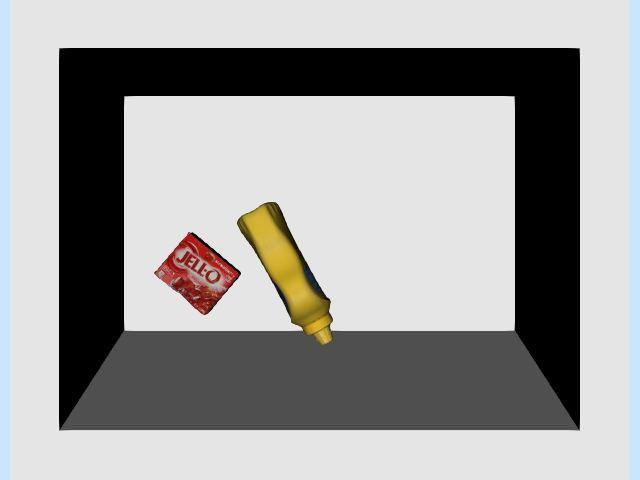

In [ ]:
dataset = BinPickingDataset(dataset_path)
dataset[0][0]

# Define the network

This cell is where the magic begins to happen.  We load a network that is pre-trained on the COCO dataset, then replace the network head with a new (untrained) network with the right number of outputs for our YCB recognition/segmentation task.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

# Transforms

Let's write some helper functions for data augmentation / transformation, which leverages the functions in torchvision `refereces/detection`. 


In [ ]:
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

# Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

## Training and Testing Datasets and their DataLoader

In [ ]:
# use our dataset and defined transformations
dataset = BinPickingDataset(dataset_path, get_transform(train=True))
dataset_test = BinPickingDataset(dataset_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model and Optimizer

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(ycb)+1

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

## Load Trainig and Evaluation Code

In [ ]:
from engine import train_one_epoch, evaluate


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [   0/4975]  eta: 3:17:49  lr: 0.000010  loss: 5.7042 (5.7042)  loss_classifier: 2.2416 (2.2416)  loss_box_reg: 0.4758 (0.4758)  loss_mask: 2.9041 (2.9041)  loss_objectness: 0.0765 (0.0765)  loss_rpn_box_reg: 0.0062 (0.0062)  time: 2.3859  data: 0.4914  max mem: 2138
Epoch: [0]  [  10/4975]  eta: 2:09:19  lr: 0.000060  loss: 5.3753 (5.4231)  loss_classifier: 2.0505 (2.0369)  loss_box_reg: 0.6212 (0.6228)  loss_mask: 2.7430 (2.7145)  loss_objectness: 0.0303 (0.0408)  loss_rpn_box_reg: 0.0062 (0.0081)  time: 1.5629  data: 0.0531  max mem: 2602
Epoch: [0]  [  20/4975]  eta: 2:05:56  lr: 0.000110  loss: 4.4558 (4.5251)  loss_classifier: 1.6621 (1.6480)  loss_box_reg: 0.5524 (0.5995)  loss_mask: 2.0363 (2.2121)  loss_objectness: 0.0414 (0.0528)  loss_rpn_box_reg: 0.0096 (0.0126)  time: 1.4820  data: 0.0103  max mem: 2602
Epoch: [0]  [  30/4975]  eta: 2:05:54  lr: 0.000160  loss: 2.7490 (3.8105)  loss_classifier: 0.8862 (1.3502)  loss_box_reg: 0.6637 (0.6428)  loss_mask: 0.9488 (

If you're going to leave this running for a bit, I recommend scheduling the following cell to run immediately (so that you don't lose your work).

In [ ]:
torch.save(model.state_dict(), 'clutter_maskrcnn_model.pt')

from google.colab import files
files.download('clutter_maskrcnn_model.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[114.3161,  93.0596, 182.9011, 182.3358],
          [212.7367, 108.4452, 282.6981, 183.3272],
          [355.3579, 139.0079, 452.2686, 206.6721],
          [386.0886, 142.5625, 524.8364, 242.0786],
          [375.1663,  91.7117, 435.7254, 140.8659],
          [226.7202,  90.2829, 385.0375, 185.8817],
          [360.8511, 142.6125, 484.4649, 218.4569],
          [294.8230, 260.3740, 477.6867, 353.8388],
          [238.1893, 112.2154, 267.8755, 183.3793],
          [229.7935, 103.1229, 346.2046, 184.2872],
          [369.7363, 144.8040, 501.9307, 227.1521]], device='cuda:0'),
  'labels': tensor([2, 2, 2, 3, 4, 3, 3, 1, 2, 2, 2], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ...,

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

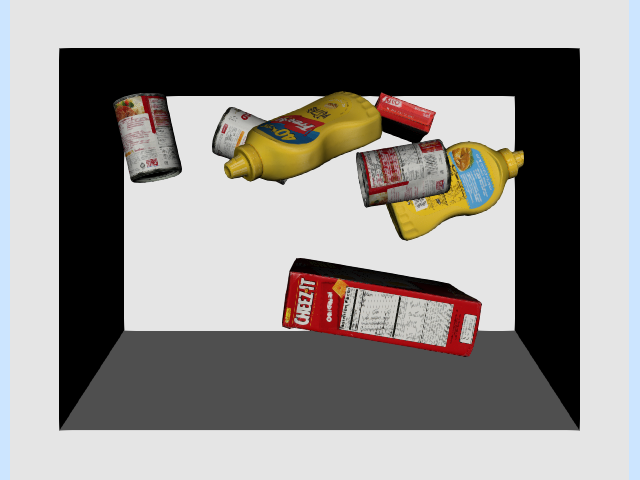

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

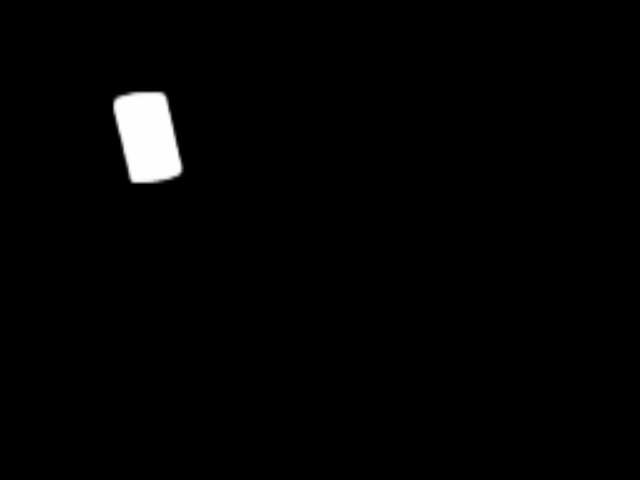

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())